# IMPORTS

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import pandas as pd

# Adding user mean, covariance and prior cluster probability

In [2]:
# Please update these here or leave it as it is to get default values
mu1 = []# Expected format [[0 , 0] , [1 , 1]]
sigma1 = []        # Expected format [[[1 , 1],[1 , 1]],[[2 , 2],[2 , 2]]]
phi1 = []       # Expected format [0.5 , 0.5]

# GMM Function, User Inputs, Jaccard & Rand Calculation and Data Visualization

Please enter file name: GMM.txt
--------------------------------------------------------------------
Please enter the number of clusters: 3
--------------------------------------------------------------------
Please enter the max number of iterations: 1000
--------------------------------------------------------------------
Please enter the smoothing value: 0.000000009
Please enter the conversion threshold: 0.000000009
--------------------------------------------------------------------


C:\Users\snigd\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
C:\Users\snigd\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply



Jaccard Coefficient = 0.5485795919582137
Rand Index = 0.75732


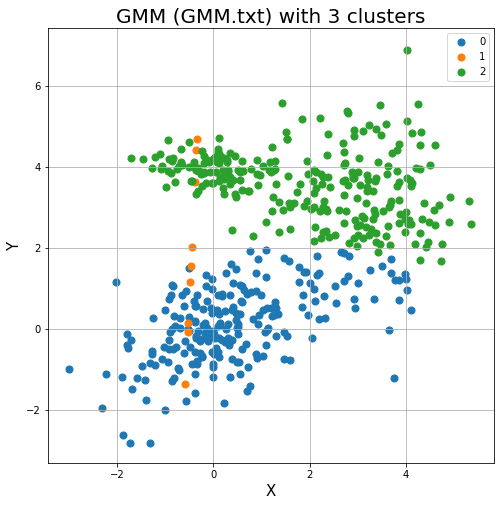

In [6]:
def GMM(X , mu, sigma, phi, conv_threshold, smoothing_value,k,max_iter):
    n, m = X.shape
    cluster_prob = np.full( (n,m), fill_value=1/k)
    # In order to prevent the occurrence of singular matrices, 
    # cov matrix should be replaced by cov+smooth_value*I, where "I" is an identity matrix. 
    
    #I1 = np.identity(features.shape[1])
    #s1 = s1 + ((0.0000001)*(I1)) This method causes few issues during iteration
    for i , ele in enumerate(sigma):
        np.fill_diagonal(sigma[i], ele.diagonal() + smoothing_value)

    old_val = None
    
    # E Step
    for iteration in range(max_iter):
        likelihood = np.zeros( (n, k) )
        for i in range(k):
            distribution = multivariate_normal(mean=mu[i], cov=sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        cluster_prob = numerator / denominator

        phi = cluster_prob.mean(axis=0)

        # M step
        for i in range(k):
            weight = cluster_prob[:, [i]]
            total_weight = weight.sum()
            mu[i] = (X * weight).sum(axis=0) / total_weight
            sigma[i] = np.cov(X.T, aweights=(weight/total_weight).flatten(), bias=True)
            # Doing this again as we have updated sigma
            for i , ele in enumerate(sigma):
                np.fill_diagonal(sigma[i], ele.diagonal() + smoothing_value)
        
        #N = X.shape[0]
        C = cluster_prob.shape[1]
        curr_val = np.zeros((n, C))
        for m in range(C):
            dist = multivariate_normal(mu[m], sigma[m],allow_singular=True)
            curr_val[:,m] = cluster_prob[:,m] * (np.log(phi[m])+dist.logpdf(X)-np.log(cluster_prob[:,m]))
        curr_val = np.sum(curr_val)
        updated_val = curr_val
        if old_val != None and abs(updated_val - old_val) <= conv_threshold:
            break
        old_val = updated_val
        # print(loss_function(X))
        
    likelihood = np.zeros( (n, k) )
    for i in range(k):
        distribution = multivariate_normal(mean=mu[i], cov=sigma[i])
        likelihood[:,i] = distribution.pdf(X)
    numerator = likelihood * phi
    denominator = numerator.sum(axis=1)[:, np.newaxis]
    cluster_prob = numerator / denominator
    return np.argmax(cluster_prob, axis=1)
     

filePath = input("Please enter file name: ") #"cho.txt" 

file = open(filePath, "r")
lines = file.readlines()

df1 = ""
# splittng the line into individual data
flag1 = 2
for line in lines:
    if(" " in line):
        flag1 = 0
    elif("\t" in line):
        flag1 = 1
    break

if(flag1 == 0):
    for line in lines:
        #data = line.strip().split(" ")
        #data_matrix.append(data)
        df1 = pd.read_csv(filePath, sep = ' ', lineterminator = '\n', header = None)
elif(flag1 == 1):
    for line in lines:
        #data = line.strip().split("\t")
        #data_matrix.append(data)
        df1 = pd.read_csv(filePath, sep = '\t', lineterminator = '\n', header = None)
else:
    print("Data should be sperated by \t or single space!")
    
df2 = df1.copy()

print("--------------------------------------------------------------------")
clusters = int(input("Please enter the number of clusters: "))
print("--------------------------------------------------------------------")
max_iters = int(input("Please enter the max number of iterations: "))
print("--------------------------------------------------------------------")
smoothing_value = float(input("Please enter the smoothing value: "))
conv_threshold = float(input("Please enter the conversion threshold: "))
print("--------------------------------------------------------------------")


#Converting it into array and getting the gene id and ground truth
#data_array = np.asarray(data_matrix, dtype = float)
gene_id = df2.iloc[:,0].values #df1data_array[:,0]
ground_truth = df2.iloc[:,1].values #data_array[:,1]
features = df2.iloc[:,2:].values #np.delete(data_array,np.s_[0:2],axis = 1)

flag = 0
phi2 = []
sigma2 = []
mu2 = []
if((len(sigma1)==0) or ((len(mu1)==0)) or ((len(phi1)==0))):
    ind = np.random.randint(0, df2.shape[0], clusters)
    p1 = np.random.randint(0, features.shape[0], clusters)
    mu1 = [features[ind,:] for ind in p1 ]
    phi1 = np.full(shape=clusters, fill_value=1/clusters)
    sigma1 = [np.cov(features.T) for _ in range(clusters)]
    flag = 1
else:
    phi2 = [np.asarray(ele , dtype = float) for ele in phi1]
    mu2 = [np.asarray(ele , dtype = float) for ele in mu1]
    sigma2 = [np.asarray(ele , dtype = float) for ele in sigma1]
        
if (flag == 1):
    obvs_truth = GMM(features , mu1, sigma1, phi1, conv_threshold, smoothing_value,clusters,max_iters)
else:
    obvs_truth = GMM(features , mu2, sigma2, phi2, conv_threshold, smoothing_value,clusters,max_iters)

obvs_truth = np.asarray(obvs_truth,dtype=int)
#obvs_truth

observed_truth_nparr = obvs_truth
df3 = df2.copy()
X_df = df3.iloc[:,2:].values
ldf = pd.DataFrame(observed_truth_nparr,columns=["Label"])

if(df2.shape[1]>4):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X_df)
    principalDf = pd.DataFrame(data = principalComponents,columns = ['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, ldf["Label"]], axis = 1)
    print()
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    til1 = "GMM ("+str(filePath)+") with "+str(clusters)+" clusters"
    ax.set_title(til1, fontsize = 20)
    targets = list(set(observed_truth_nparr))
    for pt in targets:
        indicesToKeep = finalDf['Label'] == pt
        ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], s = 50)
    ax.legend(targets)
    ax.grid()

elif(df2.shape[1]==4):
    dfnew = df3.iloc[:,2:4]
    dfnew.columns = ['X','Y']
    finalDf = pd.concat([dfnew, ldf["Label"]], axis = 1)
    print()
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('X', fontsize = 15)
    ax.set_ylabel('Y', fontsize = 15)
    til1 = "GMM ("+str(filePath)+") with "+str(clusters)+" clusters"
    ax.set_title(til1, fontsize = 20)
    targets = list(set(observed_truth_nparr))
    for pt in targets:
        indicesToKeep = finalDf['Label'] == pt
        ax.scatter(finalDf.loc[indicesToKeep, 'X'], finalDf.loc[indicesToKeep, 'Y'], s = 50)
    ax.legend(targets)
    ax.grid()
    
true_pos = 0
true_neg = 0
false_pos=0
false_neg=0
for i in range(df2.shape[0]):
    for j in range(df2.shape[0]):
        if ground_truth[i]==ground_truth[j]:
            if obvs_truth[i]==obvs_truth[j]:
                true_pos=true_pos+1
            else:
                false_neg=false_neg+1
        elif ground_truth[i]!=ground_truth[j]:
            if obvs_truth[i]==obvs_truth[j]:
                false_pos=false_pos+1
            else:
                true_neg=true_neg+1
jaccard_value=(true_pos)/(true_pos+false_pos+false_neg)
rand_index_value=(true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)

print("Jaccard Coefficient = " + str(jaccard_value))
print("Rand Index = " + str(rand_index_value))

# print(cluster_assignment)

In [17]:
len(sigma1)

2